# Transfer Learning for stacked unidirectional LSTMs
In order to evaluate the potential benefits of transfer learning with RNN networks, we take our stacked unidirectional LSTM network that was pretrained on the MITBIH dataset (https://physionet.org/physiobank/database/mitdb/), copy the weights from the LSTM layers and add two new fully connected layers with 50 neurons each together with the new output layer.  

In the first experiment we then freeze the copied layers (i.e. the LSTM layers) and train the new FC layers on the PTB dataset (https://www.physionet.org/content/ptbdb/1.0.0/).

In the second experiment we leave the transferred layers trainable.  
In the thid experiment we first freeze the copied layers and later train the whole model.

The data was downloaded from kaggle: https://www.kaggle.com/shayanfazeli/heartbeat 

### Import libraries, read the data and normalize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import optimizers, losses, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense
from keras.engine.saving import load_model
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve, \
roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
timepoints_per_sample = 187
data_path_normal = "../input/ptbdb_normal.csv"
data_path_abnormal = "../input/ptbdb_abnormal.csv"

df_1 = pd.read_csv(data_path_normal, header=None)
df_2 = pd.read_csv(data_path_abnormal, header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [3]:
# normalize without taking the zero-padding at the end into account:
for sample_idx in range(X.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X[sample_idx, 0: first_zero_sample, 0] -= np.mean(X[sample_idx, 0: first_zero_sample, 0])
    X[sample_idx, 0: first_zero_sample, 0] /= np.std(X[sample_idx, 0: first_zero_sample, 0])

for sample_idx in range(X_test.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_test[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_test[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_test[sample_idx, 0: first_zero_sample, 0])
    X_test[sample_idx, 0: first_zero_sample, 0] /= np.std(X_test[sample_idx, 0: first_zero_sample, 0])

## Frozen LSTM layers

In [4]:
# if you want to redo transfer learning set to True
perform_training = False
file_path = "../saved_trained_models/own_lstm_ptb_transfer_frozen.h5"
if perform_training:
    # load pretrained MIT model:
    old_model = load_model("../saved_trained_models/own_lstm_mitbih.h5")
    # freeze the complete old model:
    for layer in old_model.layers:
        layer.trainable = False
    # create new model with the pretrained frozen LSTM layers from the old model:
    # CAUTION: the layer name lstm_2 is hardcoded and autogenerated (not a good combination...)
    new_dense = Dense(50, activation="relu")(old_model.get_layer("lstm_2").output)
    new_dense = Dense(50, activation="relu")(new_dense)
    new_out = Dense(1, activation="sigmoid")(new_dense)

    model = Model(inputs=old_model.input, outputs=new_out)
    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(lr=0.0008), metrics=['acc'])
    model.summary()

# train the model
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, factor=0.3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]

    model.fit(X, Y, epochs=150, batch_size=160, verbose=2, callbacks=callbacks_list, validation_split=0.1)

In [5]:
# final evaluation on test data
model = load_model(file_path)
pred_test = model.predict(X_test)
freeze_prob = pred_test.copy()
pred_test[pred_test >= 0.5] = 1
pred_test[pred_test < 0.5] = 0

frozen_acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : ", frozen_acc)
frozen_f1 = f1_score(Y_test, pred_test, average="macro")
print("Test f1 score : ", frozen_f1)

Test accuracy score :  0.7997251803503951
Test f1 score :  0.7299105071821994


## Trainable LSTM layers

In [6]:
# if you want to redo transfer learning set to True
perform_training = False
file_path = "../saved_trained_models/own_lstm_ptb_transfer_trainable.h5"
if perform_training:
    # load pretrained MIT model:
    old_model = load_model("../saved_trained_models/own_lstm_mitbih.h5")
    # create new model with the pretrained frozen LSTM layers from the old model:
    # CAUTION: the layer name lstm_2 is hardcoded and autogenerated (not a good combination...)
    new_dense = Dense(50, activation="relu")(old_model.get_layer("lstm_2").output)
    new_dense = Dense(50, activation="relu")(new_dense)
    new_out = Dense(1, activation="sigmoid")(new_dense)

    model = Model(inputs=old_model.input, outputs=new_out)
    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(lr=0.0008), metrics=['acc'])
    model.summary()

    # train the model
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, factor=0.3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]

    model.fit(X, Y, epochs=150, batch_size=160, verbose=2, callbacks=callbacks_list, validation_split=0.1)

In [7]:
# final evaluation on test data
model = load_model(file_path)
pred_test = model.predict(X_test)
trainable_prob = pred_test.copy()
pred_test[pred_test >= 0.5] = 1
pred_test[pred_test < 0.5] = 0

trainable_acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : ", trainable_acc)
trainable_f1 = f1_score(Y_test, pred_test, average="macro")
print("Test f1 score : ", trainable_f1)

Test accuracy score :  0.9762968052215734
Test f1 score :  0.9704821271667332


## Frozen and then trainable LSTM layers

In [8]:
# if you want to redo transfer learning set to True
perform_training = False
file_path = "../saved_trained_models/own_lstm_ptb_transfer_frozen_then_trainable.h5"
if perform_training:
    # load pretrained MIT model:
    old_model = load_model("../saved_trained_models/own_lstm_ptb_transfer_frozen.h5")
    # make all layers trainable
    for layer in old_model.layers:
        layer.trainable = True
    # train the model
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, factor=0.3, verbose=2)
    callbacks_list = [checkpoint, early, redonplat]

    model.fit(X, Y, epochs=150, batch_size=160, verbose=2, callbacks=callbacks_list, validation_split=0.1)

In [9]:
# final evaluation on test data
model = load_model(file_path)
pred_test = model.predict(X_test)
freeze_then_trainable_prob = pred_test.copy()
pred_test[pred_test >= 0.5] = 1
pred_test[pred_test < 0.5] = 0

frozen_then_trainable_acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : ", frozen_then_trainable_acc)
frozen_then_trainable_f1 = f1_score(Y_test, pred_test, average="macro")
print("Test f1 score : ", frozen_then_trainable_f1)

Test accuracy score :  0.9783579525936105
Test f1 score :  0.9730078352384828


In [10]:
stats = pd.DataFrame({"transfer learning type":[ "freeze","train whole", "freeze then train"], \
                      "accuracy":[frozen_acc, trainable_acc, frozen_then_trainable_acc], \
                      "f1_score":[frozen_f1, trainable_f1, frozen_then_trainable_f1]})

## Results
Interestingly enough, freezing the LSTM layers results in a worse accuracy (80.06%) than the original stacked LSTM achieved for the PTB dataset (86.95%). On the other hand, copying the weights for the LSTM layers, freezing them and then training results in the best accuracy that we were able to get with a unidirectional LSTM (97.8%).

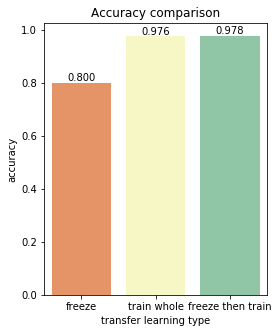

In [11]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="transfer learning type", y="accuracy", data=stats, palette="Spectral")
plt.title("Accuracy comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

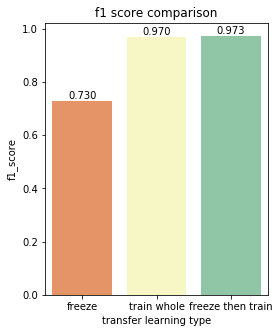

In [12]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="transfer learning type", y="f1_score", data=stats, palette="Spectral")
plt.title("f1 score comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

In [13]:
def get_baseline_resuts():
    Y = np.array(df_train[187].values).astype(np.int8)
    X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

    Y_test = np.array(df_test[187].values).astype(np.int8)
    X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    file_path = "../saved_trained_models/baseline_cnn_ptb.h5"

    model = load_model(file_path)

    pred_test_prob = model.predict(X_test)
    pred_test = (pred_test_prob>0.5).astype(np.int8)

    f1 = f1_score(Y_test, pred_test)
    acc = accuracy_score(Y_test, pred_test)

    return pred_test_prob

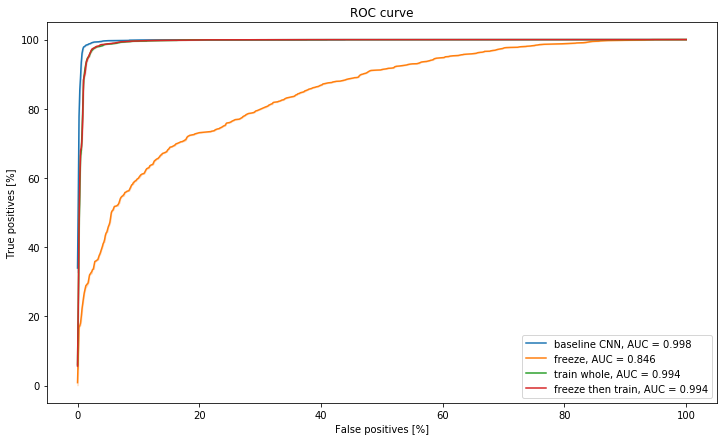

In [14]:
plt.figure(figsize=(12,7))
labels = Y_test
fp = [[],[],[],[]]
tp = [[],[],[],[]]
baseline_results = get_baseline_resuts()
fp[0], tp[0], _ = roc_curve(labels, baseline_results)
fp[1], tp[1], _ = roc_curve(labels, freeze_prob)
fp[2], tp[2], _ = roc_curve(labels, trainable_prob)
fp[3], tp[3], _ = roc_curve(labels, freeze_then_trainable_prob)

sns.lineplot(100*fp[0], 100*tp[0], label="baseline CNN, AUC = {0:.3f}".\
           format(roc_auc_score(labels, baseline_results)))
sns.lineplot(100*fp[1], 100*tp[1], label="freeze"+", AUC = {0:.3f}".\
           format(roc_auc_score(labels, freeze_prob)))
sns.lineplot(100*fp[2], 100*tp[2], label="train whole"+", AUC = {0:.3f}".\
           format(roc_auc_score(labels, trainable_prob)))
sns.lineplot(100*fp[3], 100*tp[3], label="freeze then train"+", AUC = {0:.3f}".\
           format(roc_auc_score(labels, freeze_then_trainable_prob)))
plt.title("ROC curve")
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.show()

The best performing of the transfer learning methods is when the extra layers are first frozen and then made trainable again. This approach achieves worse accuracy than the baseline by about 0.01.